In [144]:
import pymysql
import numpy as np
from numpy import random as nr
import pandas as pd
from scipy import optimize
import datetime as dtt
from WindPy import w
import statsmodels.api as sm
import matplotlib.pyplot as plt
import win32com.client
from pylab import mpl

In [145]:
w.start()
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [150]:
class WindIrsData(object):
    """从WIND中提取利率互换收盘价数据"""
    def __init__(self, type):
        """存储不同种类的IRS代码，主要期限为9M, 1Y, 2Y, 3Y, 4Y, 5Y"""
        if type == "FR007":
            self.codes = ["M0218007", "M0218008", "M0218009", "M0218010", "M0218011", "M0218012"]
            self.columns = ["FR007S9M", "FR007S1Y", "FR007S2Y", "FR007S3Y", "FR007S4Y", "FR007S5Y"]
            self.outliers = [dtt.date(2015, 5, 22)]
        elif type == "SHIBOR3M":
            self.codes = ["M0218016", "M0218017", "M0218018", "M0218019", "M0218020", "M0218021"]
            self.columns = ["SHI3MS9M", "SHI3MS1Y", "SHI3MS2Y", "SHI3MS3Y", "SHI3MS4Y", "SHI3MS5Y"]
            self.outliers = [dtt.date(2015, 5, 6), dtt.date(2015, 6, 4), dtt.date(2015, 6, 10), dtt.date(2015, 9, 21)]
        else:
            raise ValueError("不被接受的参数值type")
        self.wdata = None
        self.times = None
        self.data = None
        self.df = None
    
    def extract(self, dt1=dtt.date(2015, 1, 1), dt2=dtt.date(2018, 12, 17)):
        "从Wind中提取相应品种利率互换的日收盘价数据"
        wData = w.edb(self.codes, dt1, dt2)
        if wData.ErrorCode == 0:
            self.wdata = wData
            self.times = wData.Times
            self.data = wData.Data
            self.df = pd.DataFrame(list(zip(*self.data)), index=pd.to_datetime(self.times), columns=self.columns)
            # self.df.drop(self.outliers, inplace=True)
        else:
            raise ValueError("{}".format(wData.ErrorCode))
    
    def spreads(self):
        """分别返回9M*1Y，1*5Y，2*5Y，3*5Y，4*5Y的利差数据"""
        spreads = [self.df[self.columns[1]]-self.df[self.columns[0]], self.df[self.columns[5]]-self.df[self.columns[1]], \
                  self.df[self.columns[5]]-self.df[self.columns[2]], self.df[self.columns[5]]-self.df[self.columns[3]],\
                  self.df[self.columns[5]]-self.df[self.columns[4]]]
        res = pd.concat(spreads, axis=1)
        res.columns = ["9M*1Y", "1*5Y", "2*5Y", "3*5Y", "4*5Y"]
        return res

In [111]:
class ExcelIrsData(object):
    """类ExcelIrsData用于从Excel表中提取数据，Excel表来自于中国货币网下载"""
    def __init__(self, data_path, type):
        """使用数据文件的存储路径初始化类ExcelIrsData"""
        self.data_path = data_path
        self.xlapp = win32com.client.Dispatch("Excel.Application")
        self.type = type
        self.columns = "{0}S9M,{0}S1Y,{0}S2Y,{0}S3Y,{0}S4Y,{0}S5Y".format(self.type).split(",")
        self.df = None
        
    def extract(self, yms:list, output=False):
        """从Excel表中提取数据，表格命名方式主要依赖数据的年月，一个月一张表，参数yms即表示年月列表"""
        res = []
        for ym in yms:
            filename = self.data_path + r"\{}利率互换曲线历史数据（{}）.xlsx".format(self.type, ym)
            wb = self.xlapp.Workbooks.Open(filename)
            ws = wb.Worksheets(1)
            dd = ws.Range(ws.cells(2,1), ws.cells(2,1).offset(ws.UsedRange.Rows.Count-4, ws.UsedRange.Columns.Count-1)).Value
            data = [[d[0], float(d[7]), float(d[8]), float(d[9]), float(d[10]), float(d[11]), float(d[12])] for d in dd]
            data.sort(key=lambda d: d[0])
            res.extend(data) 
        res = pd.DataFrame(res, columns=["DT", *self.columns])
        res.set_index(["DT"], inplace=True)
        res.index = pd.to_datetime(res.index)
        self.df = res
        if output:
            return res
    
    def spreads(self):
        """计算9M*1Y，1*5Y, 2*5Y, 3*5Y, 4*5Y的利差"""
        spreads = [self.df[self.columns[1]]-self.df[self.columns[0]], self.df[self.columns[5]]-self.df[self.columns[1]], \
                  self.df[self.columns[5]]-self.df[self.columns[2]], self.df[self.columns[5]]-self.df[self.columns[3]],\
                  self.df[self.columns[5]]-self.df[self.columns[4]]]
        res = pd.concat(spreads, axis=1)
        res.columns = ["9M*1Y", "1*5Y", "2*5Y", "3*5Y", "4*5Y"]
        return res
        
        
    

,9M*1Y,1*5Y,2*5Y,3*5Y,4*5Y
DT,,,,,
2018-08-02,0.0147,0.3786,0.2883,0.1933,0.0808
2018-08-03,-0.0001,0.3955,0.3057,0.2001,0.0882
2018-08-06,0.0241,0.4146,0.3170,0.2057,0.0900
2018-08-07,0.0215,0.4172,0.3321,0.2161,0.0912
2018-08-08,0.0300,0.4268,0.3343,0.2205,0.1030
2018-08-09,0.0504,0.4234,0.3162,0.2059,0.0900
2018-08-10,0.0463,0.4241,0.3154,0.2054,0.0879
2018-08-13,0.0473,0.4058,0.3073,0.1958,0.0866
2018-08-14,0.0058,0.3842,0.2950,0.1846,0.0762


In [133]:
class Stats(object):
    """本类用于对利率互换期限利差之间的相互关系进行统计"""
    def __init__(self, type="FR007", dt1=dtt.date(2015, 1, 1), dt2=dtt.date(2018, 12, 17), datasource="Wind"):
        """初始化，type为利率互换基础利率品种，dt1为样本开始日期，dt2为样本结束日期"""
        self.type = type
        self.dt1 = dt1
        self.dt2 = dt2
        self.datasource = datasource
        self.spreads = self.get_spreads()        
    
    def get_spreads(self):
        """根据不同的数据源计算期限利差序列"""
        if self.datasource == "Wind":
            wid = WindIrsData(self.type)
            wid.extract(self.dt1, self.dt2)
            spreads = wid.spreads()
        elif self.datasource == "中国货币网":
            yms = ["2018-{}".format(month) for month in range(1,13)]
            data_path = r"F:\reports\my report\report2\数据\中国货币网"
            eid = ExcelIrsData(data_path, self.type)
            eid.extract(yms)
            spreads = eid.spreads()
        else:
            raise ValueError("错误的参数值datasource")
        return spreads
    
    @staticmethod
    def fit1(f, field, spreads):
        """单元线性回归（不带常数项）""" 
        data = spreads[[field, f]].dropna()              
        x = data.iloc[:, 0]
        y = data.iloc[:, 1]
        model = sm.OLS(y, x)
        res = model.fit()
        return res.params[0]
    
    @staticmethod
    def fit2(f, field, spreads):
        """对spreads一阶差分后进行无常数项线性回归"""
        data = spreads[[field, f]].diff().dropna()
        x = data.iloc[:, 0]
        y = data.iloc[:, 1]
        model = sm.OLS(y, x)
        res = model.fit()
        return res.params[0]       
        
    def get_params(self, dt1, dt2, fit_mode=1):
        """以1*5Y为解释变量，分别以9M*1Y，2*5Y，3*5Y，4*5Y为被解释变量进行线性回归，fit_mode为不同的回归模型"""
        params = []
        spreads = self.spreads.loc[(self.spreads.index>dt1)&(self.spreads.index<=dt2)]
        fields = ["9M*1Y", "2*5Y", "3*5Y", "4*5Y"] # 因变量字段名
        field = "1*5Y" # 自变量字段名
        for f in fields:            
            param = eval("self.fit{}(f, field, spreads)".format(fit_mode))
            params.append(param)
        return params
    
    def roll_params(self, roll_period):
        """使用滚动的方式计算单元线性回归参数，样本期为roll_period"""
        res = []
        dts = self.spreads.index
        for i in range(len(dts)-roll_period):
            dt1 = dts[i]
            dt2 = dts[i+roll_period]
            params = self.get_params(dt1, dt2)
            res.append(params)
        res = pd.DataFrame(res, index=pd.to_datetime(dts[roll_period:]), columns=["9M*1Y", "2*5Y", "3*5Y", "4*5Y"])
        return res      

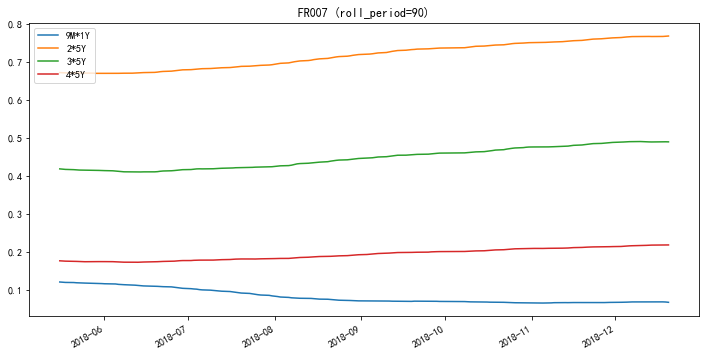

In [151]:
type = "FR007"
stats = Stats(type, dt1=dtt.date(2018, 1, 1), dt2=dtt.date(2018, 12, 20), datasource="Wind")
df = stats.roll_params(90)
df.plot(figsize=(12, 6), title="{} (roll_period=90)".format(type))
plt.legend(loc="upper left")
plt.show()

In [43]:
class IrsModel(object):
    """IrsModel类用于创建对利率互换进行定价的模型，模型的主要原理是依据某个期限点的最新的市场合理报价与成交来确定其他
    期限利率互换的合理报价，模型藉由一个维度N来进行初始化，N表示模型应当包括的期限个数，例如模型只对1Y, 2Y, 3Y, 4Y, 5Y
    这5个期限进行报价，那么N=5。初始化类时还可以提供参数矩阵B，如果不提供则需要调用estimate_B方法来对B进行估计"""
    def __init__(self, N, R0=None, B=None):
        self.N = N
        self.B = B
        self.R = R0

    def reset_R(self, R):
        """重置R，设置该方法的目的是为了能够随时按照需求来重置实例的R值，方便使用"""
        self.R = R

    def B_Matrix(self, x):
        """本方法生成一个函数，接受(N)*(N-1)个参数(即x），生成一个N*N矩阵，其对角元素均为1，该矩阵其实就是参数矩阵B，创建该
        函数的原因是为了进一步构建最小二乘函数用来估计B中的(N)*(N-1)个参数"""
        B = np.eye(self.N)
        i = 0
        for j in range(self.N):
            for k in range(self.N):
                if j == k:
                    continue
                else:
                    B[j, k] = x[i]
                    i += 1
        return B

    def receive_X(self, Xt):
        """receive方法用于接收最新的价格信息Xt，并根据Rt-1计算出价格冲击It"""
        It = np.matrix(np.zeros(self.N)).T
        index = Xt != 0
        it = Xt[index] - self.R[index]
        It[index] = it
        return It

    def It2Rt(self, It, output=False):
        """根据t时刻的价格冲击It计算各期限估值Rt"""
        self.R = self.R + np.dot(self.B, It)
        if output:
            return self.R

    def Xt2Rt(self, Xt):
        """直接由观测值Xt计算Rt"""
        It = self.receive_X(Xt)
        self.It2Rt(It) 

    def estimate_B(self, R0, sample, inplace=True):
        """estimate_B方法用于估计参数矩阵，首先根据最小二乘法构建目标函数，目标函数是一个多元二次函数，可使用牛顿迭代法
        来计算最小值，参数R0表示初始利率值，sample表示样本，即历史的价格信息流，{Xt}的时间序列"""
        self.R = R0 # 用初始值重置R

        def f(x, sample):
            res = 0
            self.B = self.B_Matrix(x)
            for X in sample:
                I = self.receive_X(X)
                self.It2Rt(I)
                res += I.T * I[0, 0]
            return res
        
        x0 = np.ones(self.N * (self.N - 1))
        res = optimize.fmin_bfgs(f, x0, args=sample)
        if inplace:
            self.B = res[0]
        return res
    

In [44]:
class Test(object):
    """Test类用于对IrsModel的有效性进行测试，两种方法分别是基于蒙特卡洛模拟以及基于历史数据的回测，Test类接受一个IrsModel类进行初始化"""
    def __init__(self, irsmodel):        
        self.im = irsmodel
        self.n = self.im.N
        
    def term_rand(self, size, p):
        """按照指定概率生成期限的索引，term_index指不同期限的利率互换在价格序列中的索引位置，p是指不同期限品种利率互换出现价格信息的概率，
        例如1Y与5Y成交报价更为频繁，相应的概率也应该更高"""
        index_range = range(self.n)
        res = nr.choice(index_range, size=size, p=p)
        return res       
        
    def generate_sample(self, num, p, R0):
        """generate_sample方法用于生成模拟的价格信息时间序列{Xt}，假定价格信息是随机游走序列，并且随机反映在某个期限品种的成交或报价上
        ，也就是说模拟价格过程有两个随机因素，一个是价格变动是一个正态分布，另一个是这一价格变动呈现在一个随机的品种上，参数num表示样
        本点个数，参数p为不同期限出现价格信息的概率，参数R0为利率初始值"""
        indexes = self.term_rand(num, p)
        Is = 0.1*nr.randn(num)
        sample = []
        self.im.reset_R(R0)
        for i, s in zip(indexes, Is):
            I = np.matrix(np.zeros(self.n)).T
            I[i, 0] = s
            R = self.im.It2Rt(I, output=True)
            X = np.zeros(self.n)
            X[i] = R[i, 0]
            sample.append(X)
        return sample

In [45]:
im = IrsModel(5)
B = im.B_Matrix(nr.rand(25))
im.B = B
R0 = np.matrix([2.5, 2.6, 2.7, 2.8, 2.9]).T
test = Test(im)
sample = test.generate_sample(500, [0.4, 0.2, 0.1, 0.05, 0.25], R0)

In [140]:
df1

,9M*1Y,2*5Y,3*5Y,4*5Y
2015-06-05,-0.153071,0.819633,0.557342,0.320714
2015-06-08,-0.145130,0.819533,0.557416,0.319287
2015-06-09,-0.137722,0.819500,0.557446,0.317927
2015-06-10,-0.185739,0.816832,0.540795,0.300442
2015-06-11,-0.178074,0.817317,0.542781,0.301531
2015-06-12,-0.171811,0.817765,0.544427,0.302152
2015-06-16,-0.167046,0.818216,0.546240,0.302429
2015-06-17,-0.162612,0.818448,0.548715,0.303339
2015-06-18,-0.158909,0.818914,0.549782,0.303628
2015-06-19,-0.155373,0.819885,0.552259,0.304407


In [152]:
df.to_csv("FR007.csv")

In [56]:
data_path = r"F:\reports\my report\report2\数据\中国货币网"
eid = ExcelIrsData(data_path, "FR007")
eid.extract_data(["2018-8"])

IndexError: string index out of range